In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
forecasting = 20

In [3]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [4]:
df = df.drop(['CellNo', 'MeasuredDate'], axis=1)
df

,Resistance,Volt,Temp
0,0.259,2.23,-20
1,0.260,2.23,-20
2,0.259,2.23,-20
3,0.259,2.23,-20
4,0.259,2.23,-20
...,...,...,...
254,0.301,2.23,-20
255,0.301,2.23,-20
256,0.302,2.23,-20
257,0.300,2.23,-20


<AxesSubplot:>

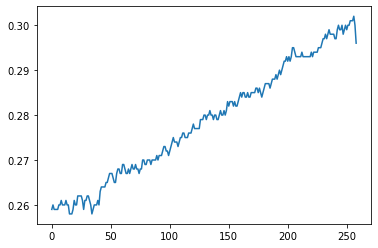

In [5]:
df['Resistance'].plot()

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [7]:
train = df_scaled

In [8]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [9]:
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)


In [10]:
x_train[0]

array([[0.        , 0.        , 0.18181818],
       [0.        , 0.        , 0.15909091],
       [0.        , 0.        , 0.15909091],
       [0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.25      ]])

In [11]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [12]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 0  # 14 for book.
P_0 = 1

In [13]:
n_samples = len(df)

In [14]:
x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(x_train, x_esti, P)
        # print(x_esti[1])
print("123", x_esti)
    # x_train[i] = x_esti

123 [[[0.         0.         0.18181818]
  [0.         0.         0.15909091]
  [0.         0.         0.15909091]
  ...
  [0.         0.         0.22727273]
  [0.         0.         0.22727273]
  [0.         0.         0.25      ]]

 [[0.         0.         0.27272727]
  [0.         0.         0.27272727]
  [0.         0.         0.25      ]
  ...
  [0.         0.         0.31818182]
  [0.         0.         0.34090909]
  [0.         0.         0.34090909]]

 [[0.         0.         0.59090909]
  [0.         0.         0.61363636]
  [0.         0.         0.61363636]
  ...
  [0.         0.         0.59090909]
  [0.         0.         0.61363636]
  [0.         0.         0.63636364]]

 ...

 [[0.         0.         0.25      ]
  [0.         0.         0.27272727]
  [0.         0.         0.27272727]
  ...
  [0.         0.         0.31818182]
  [0.         0.         0.31818182]
  [0.         0.         0.29545455]]

 [[0.         0.         0.22727273]
  [0.         0.         0.227272

In [15]:
y_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(y_train, y_esti, P)
        # print(y_esti)

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(3))

In [17]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_esti, y_esti, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
12/12 [==============================] - 1s 4ms/step - loss: 0.2796 - mean_absolute_error: 0.4623
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.2005 - mean_absolute_error: 0.3814
Epoch 3/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.1008 - mean_absolute_error: 0.2574
Epoch 4/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0193 - mean_absolute_error: 0.1092
Epoch 5/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0708
Epoch 6/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0461
Epoch 7/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0439
Epoch 8/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0385
Epoch 9/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0338
E

12/12 [==============================] - 0s 4ms/step - loss: 7.9408e-04 - mean_absolute_error: 0.0229
Epoch 73/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.9803e-04 - mean_absolute_error: 0.0216
Epoch 74/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.8466e-04 - mean_absolute_error: 0.0214
Epoch 75/1000
12/12 [==============================] - 0s 5ms/step - loss: 9.1376e-04 - mean_absolute_error: 0.0235
Epoch 76/1000
12/12 [==============================] - 0s 5ms/step - loss: 7.1825e-04 - mean_absolute_error: 0.0212
Epoch 77/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.2960e-04 - mean_absolute_error: 0.0200
Epoch 78/1000
12/12 [==============================] - 0s 6ms/step - loss: 6.2531e-04 - mean_absolute_error: 0.0198
Epoch 79/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.2246e-04 - mean_absolute_error: 0.0198
Epoch 80/1000
12/12 [==============================] - 0s 6ms/step - loss: 5.6728e-04 

Epoch 141/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.0920e-04 - mean_absolute_error: 0.0196
Epoch 142/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.9237e-04 - mean_absolute_error: 0.0211
Epoch 143/1000
12/12 [==============================] - 0s 3ms/step - loss: 5.5268e-04 - mean_absolute_error: 0.0187
Epoch 144/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.6053e-04 - mean_absolute_error: 0.0189
Epoch 145/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.0291e-04 - mean_absolute_error: 0.0193
Epoch 146/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.2167e-04 - mean_absolute_error: 0.0190
Epoch 147/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8907e-04 - mean_absolute_error: 0.0199
Epoch 148/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.4801e-04 - mean_absolute_error: 0.0217
Epoch 149/1000
12/12 [==============================] - 0s 4ms/s

12/12 [==============================] - 0s 4ms/step - loss: 5.2433e-04 - mean_absolute_error: 0.0185
Epoch 212/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.0288e-04 - mean_absolute_error: 0.0177
Epoch 213/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.6712e-04 - mean_absolute_error: 0.0189
Epoch 214/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.2686e-04 - mean_absolute_error: 0.0188
Epoch 215/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.7974e-04 - mean_absolute_error: 0.0183
Epoch 216/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4905e-04 - mean_absolute_error: 0.0181
Epoch 217/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8926e-04 - mean_absolute_error: 0.0188
Epoch 218/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.4807e-04 - mean_absolute_error: 0.0200
Epoch 219/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.5

12/12 [==============================] - 0s 4ms/step - loss: 5.3347e-04 - mean_absolute_error: 0.0188
Epoch 282/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8497e-04 - mean_absolute_error: 0.0191
Epoch 283/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1475e-04 - mean_absolute_error: 0.0180
Epoch 284/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1210e-04 - mean_absolute_error: 0.0182
Epoch 285/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.1644e-04 - mean_absolute_error: 0.0194
Epoch 286/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.2545e-04 - mean_absolute_error: 0.0171
Epoch 287/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4828e-04 - mean_absolute_error: 0.0187
Epoch 288/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.5339e-04 - mean_absolute_error: 0.0196
Epoch 289/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.7

12/12 [==============================] - 0s 4ms/step - loss: 6.5034e-04 - mean_absolute_error: 0.0195
Epoch 351/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3414e-04 - mean_absolute_error: 0.0185
Epoch 352/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.6886e-04 - mean_absolute_error: 0.0170
Epoch 353/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.2713e-04 - mean_absolute_error: 0.0179
Epoch 354/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.0391e-04 - mean_absolute_error: 0.0185
Epoch 355/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4089e-04 - mean_absolute_error: 0.0185
Epoch 356/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.7934e-04 - mean_absolute_error: 0.0174
Epoch 357/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1554e-04 - mean_absolute_error: 0.0178
Epoch 358/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.5

12/12 [==============================] - 0s 4ms/step - loss: 5.3727e-04 - mean_absolute_error: 0.0180
Epoch 420/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3421e-04 - mean_absolute_error: 0.0182
Epoch 421/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3695e-04 - mean_absolute_error: 0.0185
Epoch 422/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.5756e-04 - mean_absolute_error: 0.0172
Epoch 423/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.7432e-04 - mean_absolute_error: 0.0174
Epoch 424/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1699e-04 - mean_absolute_error: 0.0180
Epoch 425/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.5786e-04 - mean_absolute_error: 0.0185
Epoch 426/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1455e-04 - mean_absolute_error: 0.0179
Epoch 427/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.5

12/12 [==============================] - 0s 6ms/step - loss: 4.1933e-04 - mean_absolute_error: 0.0162
Epoch 490/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.7139e-04 - mean_absolute_error: 0.0175
Epoch 491/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3967e-04 - mean_absolute_error: 0.0187
Epoch 492/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.1834e-04 - mean_absolute_error: 0.0205
Epoch 493/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.9409e-04 - mean_absolute_error: 0.0196
Epoch 494/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.0704e-04 - mean_absolute_error: 0.0173
Epoch 495/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.4823e-04 - mean_absolute_error: 0.0172
Epoch 496/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.2684e-04 - mean_absolute_error: 0.0183
Epoch 497/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1

12/12 [==============================] - 0s 4ms/step - loss: 3.8871e-04 - mean_absolute_error: 0.0162
Epoch 560/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.9997e-04 - mean_absolute_error: 0.0164
Epoch 561/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1520e-04 - mean_absolute_error: 0.0180
Epoch 562/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.5128e-04 - mean_absolute_error: 0.0163
Epoch 563/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.7401e-04 - mean_absolute_error: 0.0175
Epoch 564/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.0408e-04 - mean_absolute_error: 0.0176
Epoch 565/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.8762e-04 - mean_absolute_error: 0.0164
Epoch 566/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.8754e-04 - mean_absolute_error: 0.0182
Epoch 567/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8

12/12 [==============================] - 0s 5ms/step - loss: 3.8460e-04 - mean_absolute_error: 0.0154
Epoch 629/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.7222e-04 - mean_absolute_error: 0.0166
Epoch 630/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.0861e-04 - mean_absolute_error: 0.0155
Epoch 631/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.8245e-04 - mean_absolute_error: 0.0156
Epoch 632/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.1120e-04 - mean_absolute_error: 0.0157
Epoch 633/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.1742e-04 - mean_absolute_error: 0.0156
Epoch 634/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.2199e-04 - mean_absolute_error: 0.0182
Epoch 635/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.9597e-04 - mean_absolute_error: 0.0157
Epoch 636/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.8

12/12 [==============================] - 0s 4ms/step - loss: 4.7882e-04 - mean_absolute_error: 0.0171
Epoch 699/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.3885e-04 - mean_absolute_error: 0.0162
Epoch 700/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3823e-04 - mean_absolute_error: 0.0142
Epoch 701/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5949e-04 - mean_absolute_error: 0.0146
Epoch 702/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7239e-04 - mean_absolute_error: 0.0153
Epoch 703/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6301e-04 - mean_absolute_error: 0.0146
Epoch 704/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6393e-04 - mean_absolute_error: 0.0145
Epoch 705/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.9509e-04 - mean_absolute_error: 0.0154
Epoch 706/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.1

12/12 [==============================] - 0s 4ms/step - loss: 3.9838e-04 - mean_absolute_error: 0.0150
Epoch 768/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.3352e-04 - mean_absolute_error: 0.0157
Epoch 769/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6914e-04 - mean_absolute_error: 0.0148
Epoch 770/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7452e-04 - mean_absolute_error: 0.0155
Epoch 771/1000
12/12 [==============================] - ETA: 0s - loss: 2.5991e-04 - mean_absolute_error: 0.013 - 0s 4ms/step - loss: 3.7239e-04 - mean_absolute_error: 0.0154
Epoch 772/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.3595e-04 - mean_absolute_error: 0.0161
Epoch 773/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.8795e-04 - mean_absolute_error: 0.0159
Epoch 774/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4539e-04 - mean_absolute_error: 0.0145
Epoch 775/1000
12/12 

12/12 [==============================] - 0s 4ms/step - loss: 3.3625e-04 - mean_absolute_error: 0.0138
Epoch 837/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4049e-04 - mean_absolute_error: 0.0146
Epoch 838/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.0127e-04 - mean_absolute_error: 0.0153
Epoch 839/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.9508e-04 - mean_absolute_error: 0.0147
Epoch 840/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2301e-04 - mean_absolute_error: 0.0139
Epoch 841/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2506e-04 - mean_absolute_error: 0.0131
Epoch 842/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9976e-04 - mean_absolute_error: 0.0137
Epoch 843/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6511e-04 - mean_absolute_error: 0.0140
Epoch 844/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5

12/12 [==============================] - 0s 4ms/step - loss: 3.6758e-04 - mean_absolute_error: 0.0143
Epoch 907/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3323e-04 - mean_absolute_error: 0.0149
Epoch 908/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6813e-04 - mean_absolute_error: 0.0147
Epoch 909/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2528e-04 - mean_absolute_error: 0.0142
Epoch 910/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7560e-04 - mean_absolute_error: 0.0144
Epoch 911/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.2618e-04 - mean_absolute_error: 0.0153
Epoch 912/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4187e-04 - mean_absolute_error: 0.0149
Epoch 913/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.9656e-04 - mean_absolute_error: 0.0157
Epoch 914/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6

12/12 [==============================] - 0s 4ms/step - loss: 3.8741e-04 - mean_absolute_error: 0.0150
Epoch 976/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.4500e-04 - mean_absolute_error: 0.0141
Epoch 977/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.8110e-04 - mean_absolute_error: 0.0140
Epoch 978/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7396e-04 - mean_absolute_error: 0.0142
Epoch 979/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.0698e-04 - mean_absolute_error: 0.0151
Epoch 980/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2476e-04 - mean_absolute_error: 0.0140
Epoch 981/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5310e-04 - mean_absolute_error: 0.0143
Epoch 982/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3976e-04 - mean_absolute_error: 0.0141
Epoch 983/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.2

In [18]:
new_forecasting= 20

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
# new_forecasting= len(test)

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting

# print(seq)

test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)

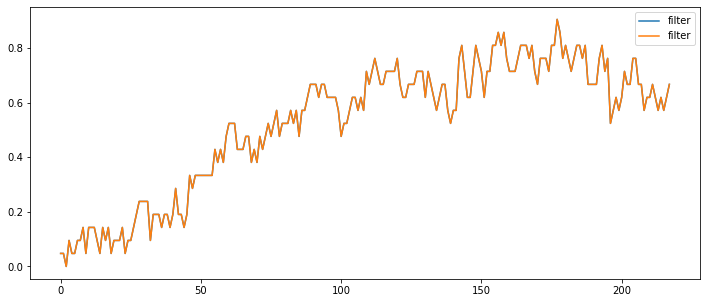

In [28]:
plt.figure(figsize=(12,5))
plt.plot(test_feature[:,0,2],label="filter")
plt.plot(x_esti[:,0,2],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

[[0.33333333 0.         0.04761905]
 [0.33333333 0.         0.04761905]
 [0.66666667 0.         0.        ]
 [0.33333333 0.         0.0952381 ]
 [0.66666667 0.         0.04761905]
 [0.33333333 0.         0.04761905]
 [0.66666667 0.         0.0952381 ]
 [0.66666667 0.         0.0952381 ]
 [0.33333333 0.         0.14285714]
 [0.33333333 0.         0.04761905]
 [0.33333333 0.         0.14285714]
 [0.33333333 0.         0.14285714]
 [0.66666667 0.         0.14285714]
 [0.66666667 0.         0.0952381 ]
 [0.33333333 0.         0.04761905]
 [0.33333333 0.         0.14285714]
 [0.33333333 0.         0.0952381 ]
 [0.66666667 0.         0.14285714]
 [0.66666667 0.         0.04761905]
 [0.66666667 0.         0.0952381 ]]
Test Score:  [0.0040643648244440556, 0.05120473355054855]


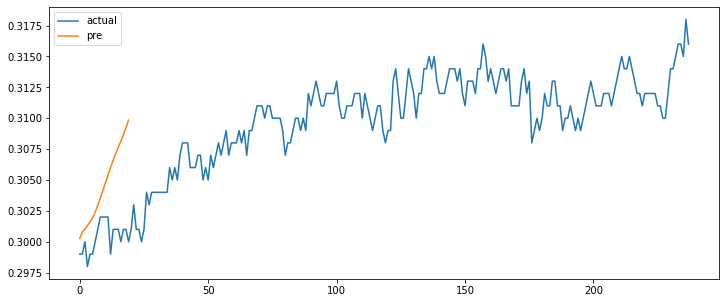

In [30]:


look_ahead=new_forecasting
xhat = x_esti[0]
print(xhat)
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=16)
    predictions[i] = prediction
    xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()